## Importing libraries

In [12]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import timeit
from scipy import misc
from os.path import join

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
from PIL import Image
from matplotlib import pyplot
import visualkeras
from keras.utils.vis_utils import plot_model

# Deep learning libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Accuracy libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold,  cross_val_score
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import sensitivity_score 
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix

## Importing data

In [13]:
labels = ['COVID', 'Normal']
#img_size = 299
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                #resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([img, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

Import train data (80% of data)

In [14]:
path = 'C:/Users/dania/Documents/Datasets/COVID-19_Radiography_Dataset/train'
train_df = get_data(path)

In [15]:
train_df.shape

(11047, 2)

In [16]:
#train_df = train_df[:1000]
#train_df.shape

Import test data (20% of data)

In [17]:
path = 'C:/Users/dania/Documents/Datasets/COVID-19_Radiography_Dataset/test'
test_df = get_data(path)

In [18]:
#test_df = test_df[:1000]
#test_df.shape

Visualize categorical data

C:\Users\dania\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

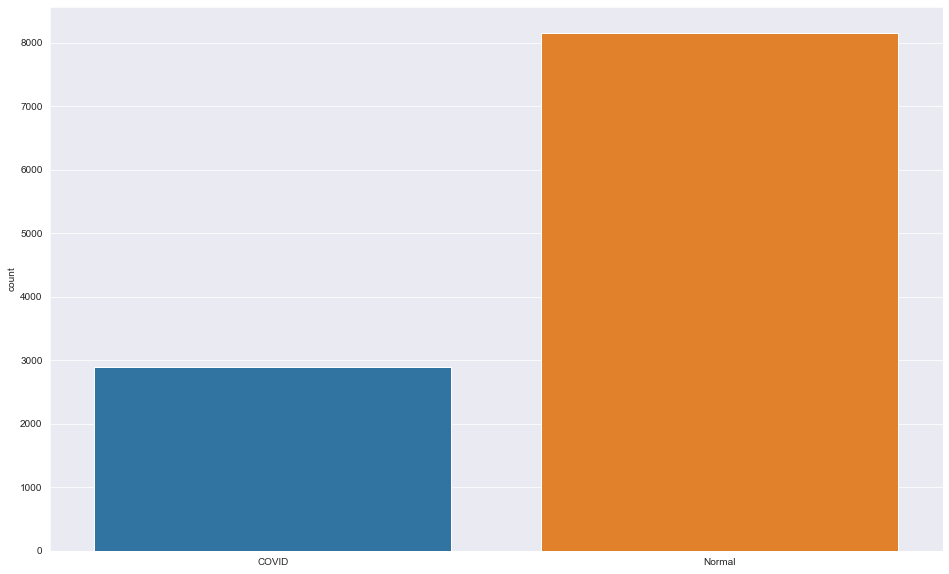

In [19]:
# train data
m = []
for i in train_df:
    if(i[1] == 0):
        m.append("COVID")
    else:
        m.append("Normal")

sns.set_style('darkgrid')
sns.countplot(m)

C:\Users\dania\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

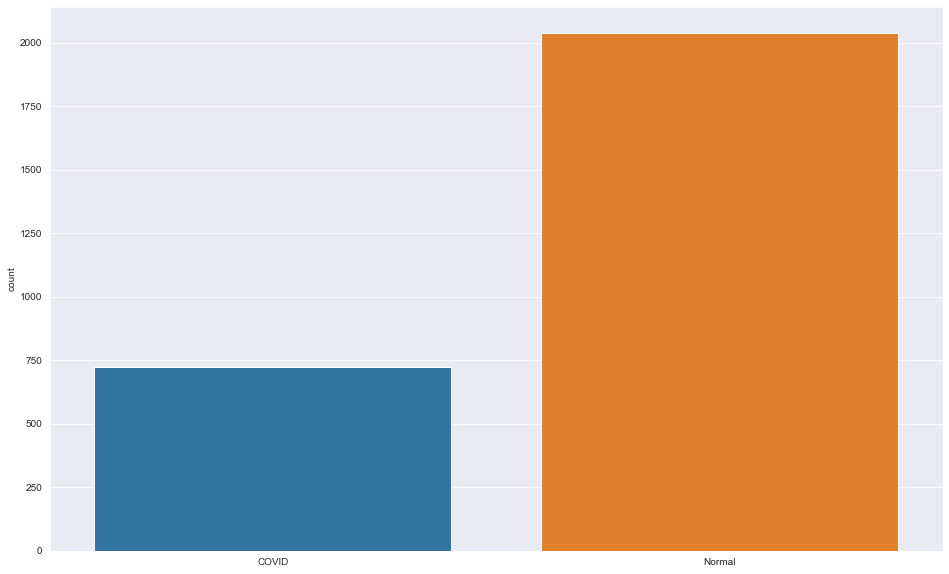

In [20]:
# test data
n = []
for i in test_df:
    if(i[1] == 0):
        n.append("COVID")
    else:
        n.append("Normal")

sns.set_style('darkgrid')
sns.countplot(n)

## Image preprocessing and augmentation

Data processing

In [6]:
x_train = []
y_train = []
x_test = []
y_test = []
img_size = 299
for feature, label in train_df:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_df:
    x_test.append(feature)
    y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

Image augmentaiton (only for demonstration)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
datagen.fit(x_train)

In [ ]:
datagen.fit(x_test)

## CNN models

Convolutional Nueral Network model.
Network sequence:

1. 2D convolutional layer with 3x3 window kernel for convolution. The activaiton is Relu for all neurons. This layer produces a feature map of 100x100x32.

2. 2D convolutional layer. This layer has same configuration as the first one and it will create a feature map of 100x100x64.

3. Max pooling layer is used to remove any overfitting in the model by passing only the features with high importance. It will reduce 100x100x64 feature map into 50x50x64.

4. Flatten layer for converting mox pooling 3D feature map into single column of features.

5. Dense layer decides which features belong to which class and it uses softmax as an activation function.

6. Dropout layer is used to prevent over-fitting by reducing complexity of the model

7. Dense layer

8. Dropout layer

9. Dense layer

In [3]:
def cnn_model():
    size = (299,299,3)
    num_cnn_layers =2
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 120
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))
  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Dense(int(MAX_NEURONS/2), activation='relu'))  #run with one less layer
    #model.add(Dropout(0.4))
    model.add(Dense(3, activation='sigmoid'))  #sigmoid is also known as logistic which is used for binary classification
    
    # compiling the model
    opt = Adam(learning_rate = 0.000001) #learning rate different from state-of-the-art model (0.001 to 0.000001 reduction)
    model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
    
    return model

In [4]:
model = cnn_model()

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1420864)           0         
_________________________________________________________________
dense (Dense)                (None, 120)               170503800 
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

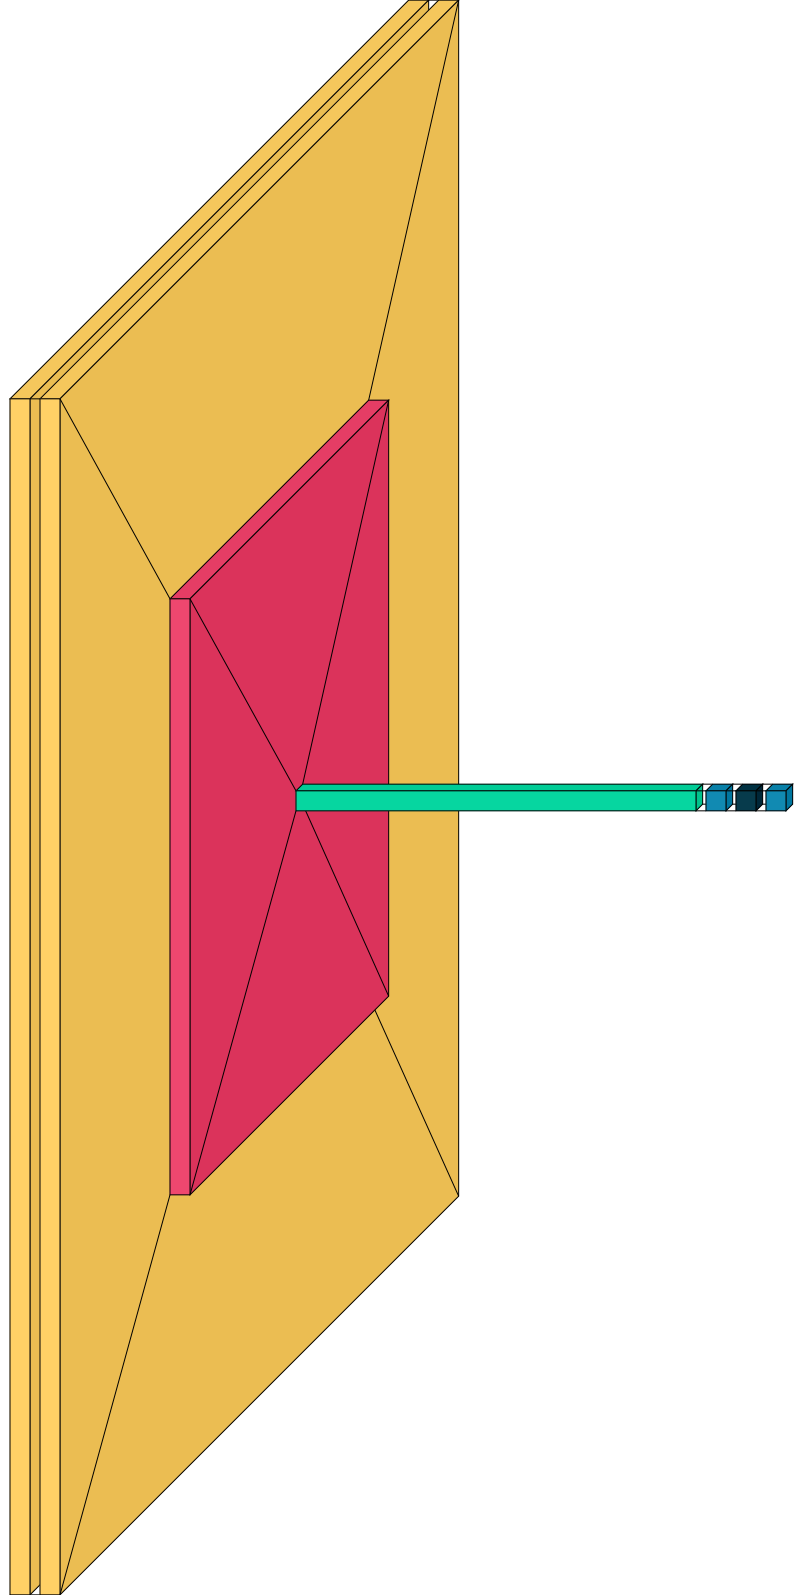

In [7]:
visualkeras.layered_view(model)

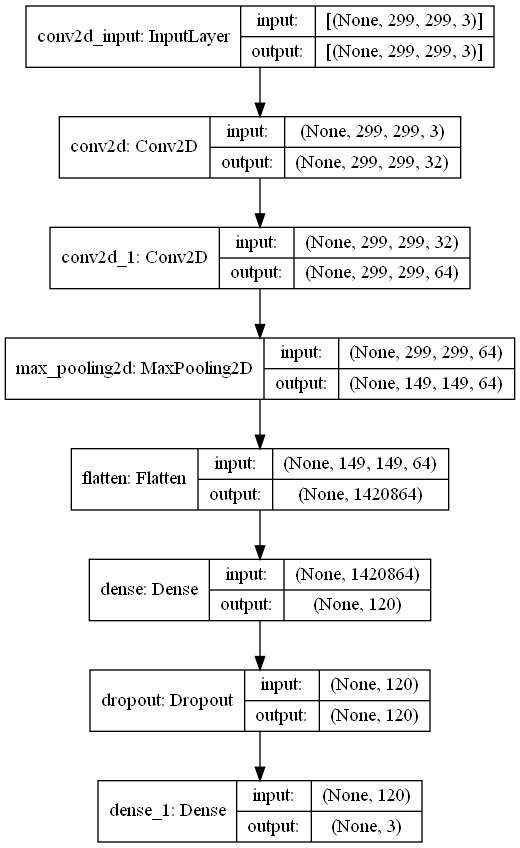

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Fitting the model to train data

In [10]:
start = timeit.default_timer()

history = model.fit(x_train, y_train, epochs = 25 , validation_data = (x_test, y_test))  # epochs = 500

end = timeit.default_timer()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
print("Run time: {:0>2} hrs {:0>2} mins {:05.2f} sec".format(int(hours), int(minutes), seconds))

Epoch 1/25


C:\Users\dania\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


346/346 [==============================] - 2732s 8s/step - loss: 0.5502 - accuracy: 0.7517 - val_loss: 0.5496 - val_accuracy: 0.6882
Epoch 2/25
346/346 [==============================] - 2674s 8s/step - loss: 0.4130 - accuracy: 0.8164 - val_loss: 0.5188 - val_accuracy: 0.7418
Epoch 3/25
346/346 [==============================] - 2678s 8s/step - loss: 0.3893 - accuracy: 0.8278 - val_loss: 0.5148 - val_accuracy: 0.7389
Epoch 4/25
346/346 [==============================] - 2707s 8s/step - loss: 0.3656 - accuracy: 0.8393 - val_loss: 0.4921 - val_accuracy: 0.7534
Epoch 5/25
346/346 [==============================] - 2748s 8s/step - loss: 0.3573 - accuracy: 0.8414 - val_loss: 0.4865 - val_accuracy: 0.7657
Epoch 6/25
346/346 [==============================] - 2688s 8s/step - loss: 0.3470 - accuracy: 0.8557 - val_loss: 0.4813 - val_accuracy: 0.7671
Epoch 7/25
346/346 [==============================] - 2684s 8s/step - loss: 0.3183 - accuracy: 0.8645 - val_loss: 0.4620 - val_accuracy: 0.7729
Epo

## Plotting results

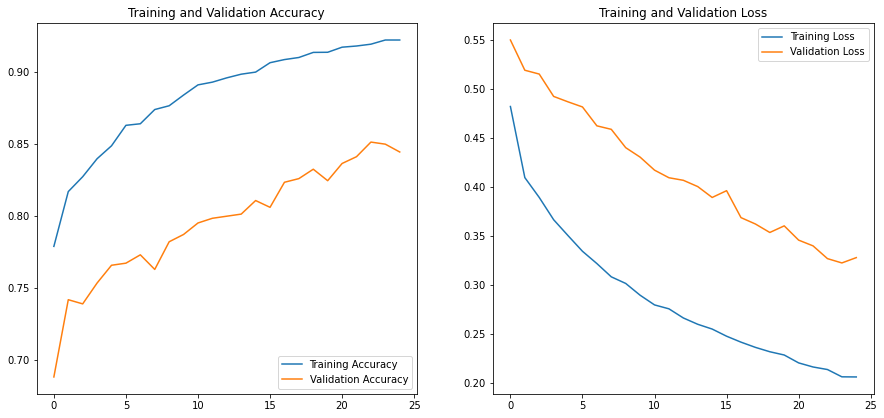

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

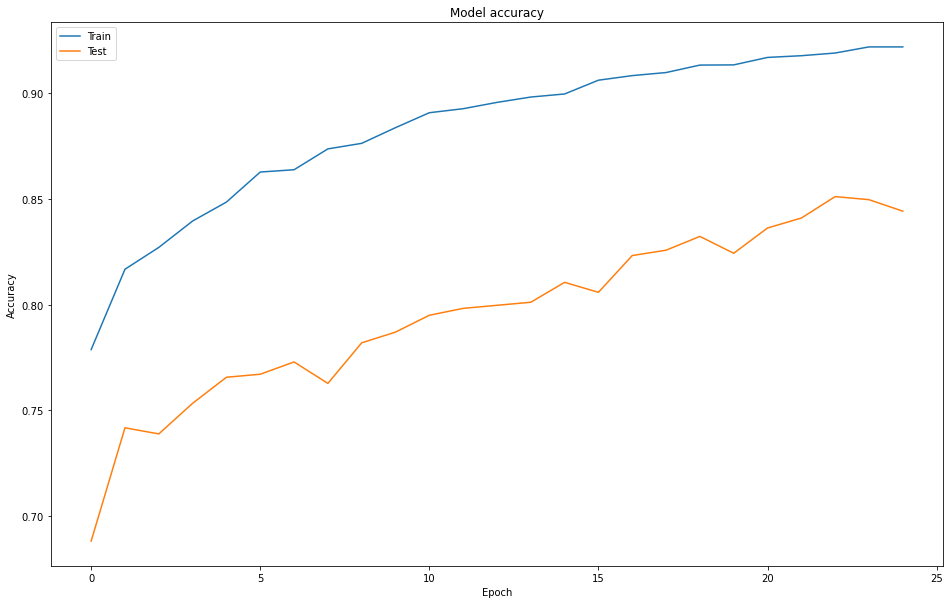

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predictions

In [15]:
predictions = model.predict_classes(x_test)
# converting predictions into 1D array
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['COVID','Normal']))

C:\Users\dania\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

       COVID       0.78      0.56      0.65       723
      Normal       0.86      0.94      0.90      2038

    accuracy                           0.84      2761
   macro avg       0.82      0.75      0.78      2761
weighted avg       0.84      0.84      0.84      2761



## Accuracies

In [19]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(predictions, y_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(predictions, y_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(predictions, y_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(predictions, y_test)
print('F1 score: %f' % f1)
# Sensitivity
sensitivity = sensitivity_score(predictions, y_test)
print('Sensitivity: %f' % sensitivity)
# Specificity
specificity = specificity_score(predictions, y_test)
print('Specificity: %f' % specificity)
# Geometric mean score
geom_mean = geometric_mean_score(predictions, y_test)
print('Geometric mean: %f' % geom_mean)
# confusion matrix
matrix = confusion_matrix(predictions, y_test)
print('Confusion matrix:')
print(matrix)

Accuracy: 0.844259
Precision: 0.943572
Recall: 0.859249
F1 score: 0.899439
Sensitivity: 0.859249
Specificity: 0.780115
Geometric mean: 0.818726
Confusion matrix:
[[ 408  115]
 [ 315 1923]]
